In [281]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

# Dynamic fee algorithm

"token1": {
          "decimals": "18",
          "symbol": "WETH"
        },
"token0": {
  "decimals": "6",
  "symbol": "USDC"
},

amount0: how many of USDC the pool received during this swap 

amount1: how many of WETH the pool received during this swap

if amount1 is positive, it means the pool received a sell order of WETH.

if amount1 is negative, it means the pool received a buy order of WETH.

In [134]:
df = pd.concat([pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl'), pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl'), pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')],axis=0)
df.drop_duplicates(inplace=True)
df.set_index('time_dex', inplace=True)

In [358]:
def zscore(series):
    return (series - series.mean()) / series.std()

# in percentage
def calculate_dynamic_buy_fees(row, f_min, f_max, w):
    return min(f_max, f_min + w * max(0, row['delta_p']))

def calculate_dynamic_sell_fees(row, f_min, f_max, w):
    return min(f_max, f_min - w * min(0, row['delta_p']))

# y = 42.95x^2 + 7.16x + 157.85
# + means buy fee, - means sell fee
def calculate_dynamic_fee_quadratic(row, a, b, c):
    x = row['delta_p']
    return (a*np.square(x) + b*x + c)

# based on the trade direction 
def calculate_fee_direction(row):
    return (row['f_buy'] if row['amount1'] < 0 else row['f_sell'])*row['amountUSD']/100 + 0.05


# run after fee_directional is calculated, in USD
# TODO: minus gas
def calculate_arbitrageur_profit_dynamic(row):
    return row['LVR'] - row['dynamic_fee'] - row['tcost_usd']


# divide by notional amount -- percentage profits
# pool_fee is kept
def calculate_arbitrageur_profit_fixed(row):
    return (row['LVR'] - row['tcost_usd'])/row['amountUSD']

def calculate_arbitrageur_profit_dynamic_quadratic(row):
    return row['LVR'] - row['f_quadratic']*row['amountUSD'] - row['tcost_usd']

# in percentage
# TODO ????
def calculate_price_impact(row):
    k = (row['amount0']/row['amount1']).abs()
    
    return row['price_dex']*row['amount1']



In [359]:
f_min= 0.01
f_max = 0.3
# the steeper w is, the larger delta p is punished
w = (f_max - f_min)/np.abs(df['delta_p']).mean()
w = 0.1

a=49.82
b=44.13
c=-67.72

print(f'w is {w: .3f}')

df['pool_fee'] = df['amountUSD']*0.05/100
df['delta_p'] = zscore(df['price_cex']-df['price_dex'])
# in %
df['f_buy'] = df.apply(lambda row: calculate_dynamic_buy_fees(row, f_min, f_max, w), axis=1)
df['f_sell'] = df.apply(lambda row: calculate_dynamic_sell_fees(row, f_min, f_max, w), axis=1)
df['f_quadratic'] = df.apply(lambda row: calculate_dynamic_fee_quadratic(row, a, b, c), axis=1)
# in USD
df['dynamic_fee'] = df.apply(lambda row: calculate_fee_direction(row), axis=1)
df['arb_profit_dynamic'] =  df.apply(lambda row: calculate_arbitrageur_profit_dynamic(row), axis=1)
df['arb_profit_fixed'] =  df.apply(lambda row: calculate_arbitrageur_profit_fixed(row), axis=1)
df['arb_profit_quadratic'] =  df.apply(lambda row: calculate_arbitrageur_profit_dynamic_quadratic(row), axis=1)
# in %
df['price_impact'] = (df['price_dex'].pct_change(1).shift(-1)*100).fillna(method='bfill').fillna(method='ffill')

df

w is  0.100


,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,f_sell,dynamic_fee,arb_profit_dynamic,arb_profit_fixed,winsorized_delta_p,winsorized_profits,price_impact,f_quadratic,arb_profit_dynamic_quadratic,arb_profit_quadratic
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:23,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,0.010000,4.648518,-20.362978,-0.000869,0.154395,-24.752595,0.000000,-59.718931,1.079480e+06,1.079480e+06
2024-01-01 00:00:23,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,0.010000,0.227876,-10.559101,-0.014776,0.154395,-10.680831,0.010000,-59.718931,4.174590e+04,4.174590e+04
2024-01-01 00:00:47,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,0.010000,20.633333,-44.388026,-0.000951,0.724286,-36.240241,0.000000,-9.622129,2.402513e+05,2.402513e+05
2024-01-01 00:00:59,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,0.010000,0.682083,-8.151670,-0.009741,0.724286,-7.852999,0.000000,-9.622129,7.371015e+03,7.371015e+03
2024-01-01 00:01:23,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,0.010000,0.110400,-88.193521,-0.515993,0.253825,-88.168474,0.010000,-53.308949,9.012076e+03,9.012076e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 23:59:23,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,0.010885,0.298179,-20.961339,-0.009062,-0.008847,-21.803197,0.000000,-68.106509,1.552672e+05,1.552672e+05
2024-01-31 23:59:47,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,0.010000,1.752306,-14.619501,-0.000858,0.013556,-20.362632,0.070021,-67.112612,1.006064e+06,1.006064e+06
2024-01-31 23:59:59,164318.889753,-71.961440,164190.258312,0x1fd0c666094d8c5dae247aa6c3c4c33fd21bdc91,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.706746e+09,1673514,2.378692e+10,2.378692e-08,...,0.080225,16.469026,7.824078,0.000148,-0.702250,-57.802025,0.000000,-74.141301,1.217330e+07,1.217330e+07


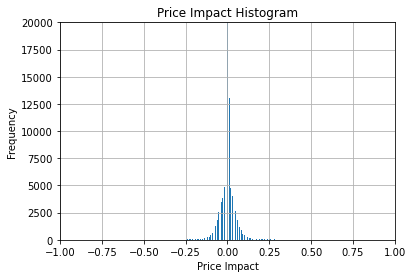

In [252]:
df['price_impact'].hist(bins=1000)
plt.xlim(-1,1)
plt.ylim(0,20000)
plt.title('Price Impact Histogram')
plt.xlabel('Price Impact')
plt.ylabel('Frequency')
plt.show()

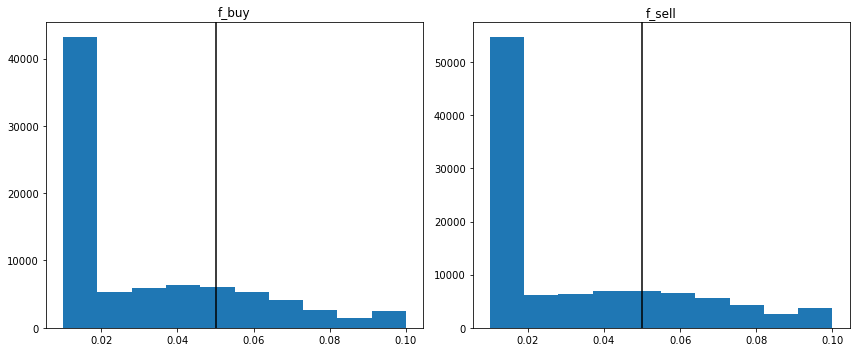

In [165]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

axs[0].hist(df[df['amount1'] < 0]['f_buy'])
axs[1].hist(df[df['amount1'] > 0]['f_sell'])
axs[0].set_title('f_buy')
axs[1].set_title('f_sell')
axs[0].axvline(x=0.05, color='black')
axs[1].axvline(x=0.05, color='black')
plt.tight_layout()
plt.show()

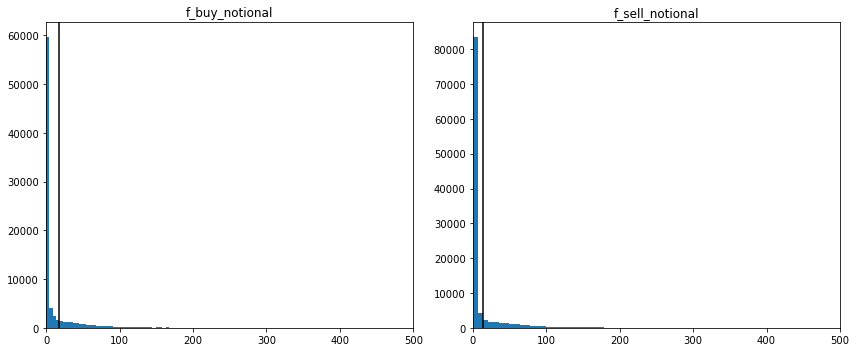

In [173]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

avg_buy, avg_sell = df[df['amount1'] < 0]['dynamic_fee'].mean(), df[df['amount1'] > 0]['dynamic_fee'].mean()

axs[0].hist(df[df['amount1'] < 0]['dynamic_fee'],bins=1000)
axs[0].set_xlim(0,500)
axs[1].hist(df[df['amount1'] > 0]['dynamic_fee'],bins=1000)
axs[0].set_title('f_buy_notional')
axs[1].set_title('f_sell_notional')
axs[1].set_xlim(0,500)
axs[0].axvline(x=avg_buy, color='black')
axs[1].axvline(x=avg_sell, color='black')
plt.tight_layout()
plt.show()

In [278]:
print(f"average f_buy is {df['f_buy'].mean():.4f}; average f_sell is {df['f_sell'].mean():.4f}")

average f_buy is 0.0296; average f_sell is 0.0306


f_sell is systematically higher than f_buy because Price on Dex is higher than Price on CEX 

In [188]:
# only take postive LVR
df[df['LVR']>0]['arb_profit_dynamic'].sum()/df[df['LVR']>0]['arb_profit_fixed'].sum()

1.755338372300377

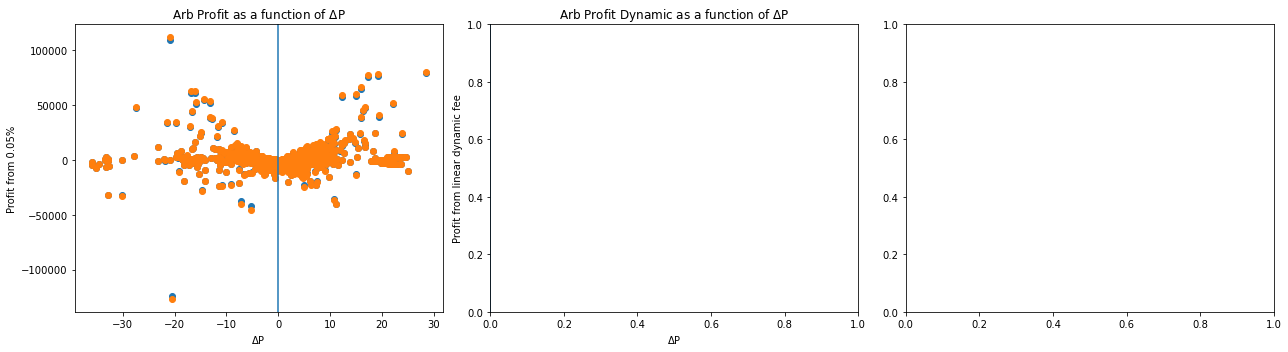

In [301]:
fig, axs = plt.subplots(1,3,figsize=(18,5))
axs[0].scatter(df['delta_p'].to_numpy(), df['arb_profit_fixed'].to_numpy())
axs[0].set_title('Arb Profit as a function of $\Delta$P')  # Title of the plot
axs[0].set_ylabel('Profit from 0.05%')  # X-axis label
axs[0].set_xlabel('$\Delta$P')  # Y-axis label
axs[0].axvline(x=df['delta_p'].mean())

axs[1].scatter(df['delta_p'].to_numpy(), df['arb_profit_dynamic'].to_numpy())
axs[1].set_title('Arb Profit Dynamic as a function of $\Delta$P')  # Title of the plot
axs[1].set_ylabel('Profit from linear dynamic fee')  # X-axis label
axs[1].set_xlabel('$\Delta$P')  # Y-axis label
axs[1].axvline(x=df['delta_p'].mean())

axs[2].scatter(df['delta_p'].to_numpy(), df['arb_profit_quadratic'].to_numpy())
axs[2].set_title('Arb Profit Dynamic quadratic as a function of $\Delta$P')  # Title of the plot
axs[2].set_ylabel('Profit from quadratic dynamic fee')  # X-axis label
axs[2].set_xlabel('$\Delta$P')  # Y-axis label
axs[2].axvline(x=df['delta_p'].mean())

plt.tight_layout()
plt.show()  # Display the plot

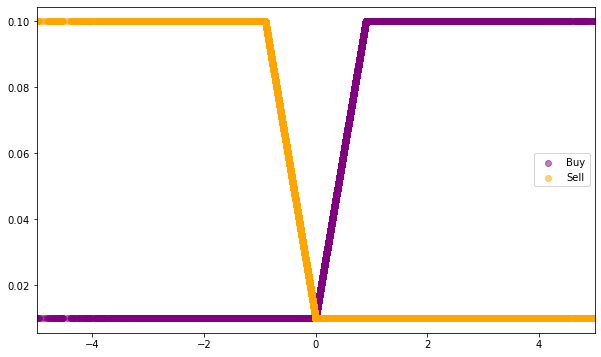

In [355]:
plt.figure(figsize=(10, 6))
def calculate_dynamic_fee_quadratic(row, a, b, c):
    x = row['delta_p']
    return (a*np.square(x) + b*x + c)/row['amountUSD']/100
plt.scatter(df['delta_p'], df['f_buy'], color='purple', alpha=0.5, label='Buy')
plt.scatter(df['delta_p'], df['f_sell'], color='orange', alpha=0.5, label='Sell')
plt.xlim(-5,5)
q = zscore(df['f_quadratic'])
# q[q>0.1] = 1
# q[q<0.01] = -1
# plt.scatter(df['delta_p'], q, color='green', alpha=0.5, label='Quadratic')

plt.legend()
plt.show()

# calibrate $\omega$ on buy and sell side
## delta_p and Arb Profit
### linear Regression

In [ ]:
# profit % kept by arbitrageur after dynamic fee
intercept_constant = 0.002
f_min=0.0001
f_max=0.003

def calc_f_dynamic(row, f_min, f_max, intercept_constant):
    return min(f_max, f_min + max(0, row['f_dynamic']-intercept_constant))
def calc_uv3_notional_profit(row):
    return row['notional_profit']-0.0005*row['amountUSD']
def calc_damm_notional_profit(row):
    return row['notional_profit'] - row['f_dynamic']*row['amountUSD']

Arbitrageur txs percentage: 3.0850%
OLS Model Parameters:
  Slope: 0.0009
  Intercept: -0.0003


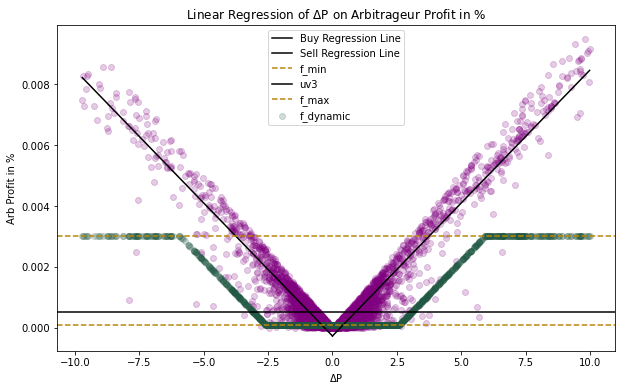

In [474]:

df_winsorize = df[(df['delta_p'] >= -10) & (df['delta_p'] <= 10) & (df['arb_profit_fixed'] >= 0) & (df['arb_profit_fixed'] <= 100)][['delta_p','arb_profit_fixed','amountUSD']].reset_index(drop=True)
df_winsorize['notional_profit'] = df_winsorize.apply(lambda row: row['arb_profit_fixed']*row['amountUSD'], axis=1)
delta_mean = df_winsorize['delta_p'].mean()
# keep the index of sell orders, and convert delta_p to positive
index_sell = df_winsorize[df_winsorize['delta_p']<0].index
df_winsorize['delta_p'] = df_winsorize['delta_p'].abs()

X, y = df_winsorize['delta_p'].values.reshape(-1,1), df_winsorize['arb_profit_fixed']

print(f"Arbitrageur txs percentage: {len(df_winsorize)/len(df)*100:.4f}%")
model_ols = LinearRegression()
model_ols.fit(X, y)
y_pred = model_ols.predict(X)

print("OLS Model Parameters:")
print(f"  Slope: {model_ols.coef_[0]:.4f}")
print(f"  Intercept: {model_ols.intercept_:.4f}")


df_winsorize.loc[index_sell, 'delta_p'] = -df_winsorize.loc[index_sell, 'delta_p']
df_winsorize['f_dynamic'] = np.array(y_pred)
df_winsorize['f_dynamic'] = df_winsorize.apply(lambda row: calc_f_dynamic(row, f_min, f_max, intercept_constant), axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='purple', alpha=0.2)
plt.xlabel("$\Delta$P")
plt.ylabel("Arb Profit in %")
plt.title("Linear Regression of $\Delta$P on Arbitrageur Profit in %")

line_x_buy = np.array([0, X.max()])
line_y_buy = model_ols.coef_[0] * line_x_buy + model_ols.intercept_
plt.plot(line_x_buy, line_y_buy, color='black', label='Buy Regression Line')

line_x_sell = np.array([X.min(), 0])
line_y_sell = model_ols.coef_[0] * line_x_sell * (-1) + model_ols.intercept_
plt.plot(line_x_sell, line_y_sell, color='black', label='Sell Regression Line')

plt.axhline(y=f_min, label='f_min', color='#B8860B', linestyle='--')
plt.axhline(y=0.0005, label='uv3', color='black')
plt.axhline(y=f_max, label='f_max',color='#B8860B', linestyle='--')

# plt.plot(line_x_sell, line_y_sell-intercept_constant, color='#228B22', label='f_sell')
# plt.plot(line_x_buy, line_y_buy-intercept_constant, color='#228B22', label='f_buy')
plt.scatter(X, df_winsorize['f_dynamic'], color='#205843', alpha=0.2, label="f_dynamic")

plt.legend()
plt.show()



94.7888% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: 0.0006
84.3144% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: 0.0004


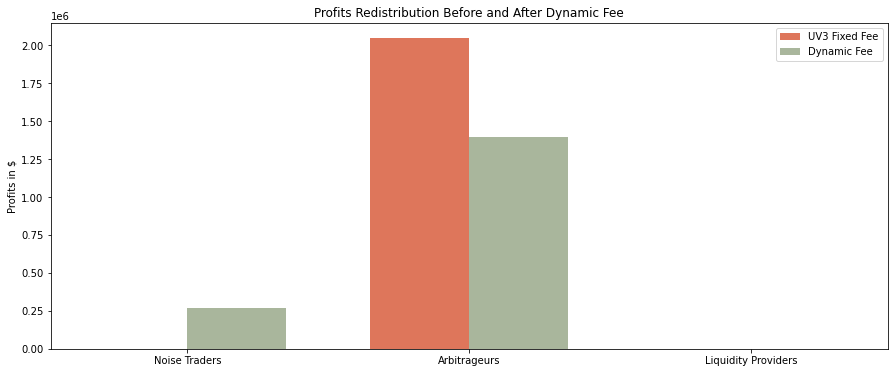

In [494]:

condition_ratio_2 = (df_winsorize['delta_p'] >= -2) & (df_winsorize['delta_p'] <= 2)
tx_ratio_2 = df_winsorize[condition_ratio_2]
tx_outside_2 = df_winsorize[~condition_ratio_2]
tx_ratio_5 = df_winsorize[(df_winsorize['delta_p'] >= -5) & (df_winsorize['delta_p'] <= 5)]
avg_profit_ratio_2 = tx_ratio_2['arb_profit_fixed'].mean()
avg_profit_ratio_5 = tx_ratio_5['arb_profit_fixed'].mean()

print(f"{len(tx_ratio_5)/len(df_winsorize)*100:.4f}% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: {avg_profit_ratio_5:.4f}")
print(f"{len(tx_ratio_2)/len(df_winsorize)*100:.4f}% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: {avg_profit_ratio_2:.4f}")

# notional profits for ΔP in [-2,2]
avg_notional_uv3_ratio_2 = tx_ratio_2.apply(lambda row: calc_uv3_notional_profit(row), axis=1)
avg_notional_damm_ratio_2 = tx_ratio_2.apply(lambda row: calc_damm_notional_profit(row), axis=1)
# profits for ΔP outside of [-2,2], AKA large price difference
avg_notional_uv3_outside_2 = tx_outside_2.apply(lambda row: calc_uv3_notional_profit(row), axis=1)
avg_notional_damm_outside_2 = tx_outside_2.apply(lambda row: calc_damm_notional_profit(row), axis=1)

# Categories and data
categories = ['Noise Traders', 'Arbitrageurs', 'Liquidity Providers']
values1 = [avg_notional_uv3_ratio_2.sum(), avg_notional_uv3_outside_2.sum(), 0]  # Values for the first group in each category
values2 = [avg_notional_damm_ratio_2.sum(), avg_notional_damm_outside_2.sum(), 0]  # Values for the second group in each category

# Bar settings
width = 0.35  # Width of the bars
ind = np.arange(len(categories))  # The x locations for the groups

# Plotting
fig, ax = plt.subplots(figsize=(15,6))
bars1 = ax.bar(ind - width/2, values1, width, label='UV3 Fixed Fee', color='#DE765B')
bars2 = ax.bar(ind + width/2, values2, width, label='Dynamic Fee', color='#A9B69C')

# Labels, title, and legend
ax.set_ylabel('Profits in $')
ax.set_title('Profits Redistribution Before and After Dynamic Fee')
ax.set_xticks(ind)
ax.set_xticklabels(categories)
ax.legend()

# Showing the plot
plt.show()




### Weighted Least Squares